In [3]:
# !jupyter nbconvert --to html "classifier_mel_based.ipynb"

# !jupyter nbconvert \
#      --TagRemovePreprocessor.enabled=True \
#      --TagRemovePreprocessor.remove_cell_tags="['ignore-in-py']" \
#      --to script "classifier_mel_based.ipynb" --output "./classifier_mel_based"

In [4]:
import datetime as dt
import math
import os
from random import choice

from keras.models import load_model
import numba
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from pathlib import Path
from scipy.sparse.linalg import spsolve
from sympy import *

2023-04-24 15:36:22.734095: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-24 15:36:23.600501: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-24 15:36:23.605403: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 15:36:28.114568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
def baseline_correction(raman_spectra, lam, p, niter=10):
    i = 0
    while raman_spectra[i] == 0:
        i += 1

    # according to "Asymmetric Least Squares Smoothing" by P. Eilers and H. Boelens
    baseline_data = np.zeros(564 - i - 1)
    curr_dataset = raman_spectra[i:]
    # this is the code for the fitting procedure
    L = len(curr_dataset)
    w = np.ones(L)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L - 2))
    for jj in range(int(niter)):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * curr_dataset)
        w = p * (curr_dataset > z) + (1 - p) * (curr_dataset < z)
    # end of fitting procedure

    baseline_data = z

    baseline_data = np.concatenate((np.zeros(i), baseline_data))
    return baseline_data


# kr0, kr1 = 17.354178,2.883237
ks0, ks1, ks2 = -1.627857, 1.235633, 0.0


def channel_to_energy_channel(ch, ks0, ks1, ks2):
    return ks0 + ks1 * ch + ks2 * ch ** (2)


def calibrate_spectrum_by_energy(spectrum):
    spectrum.rename(columns={0: 'channel', 1: 'counts'}, inplace=True)
    counts_orig = spectrum['counts'].values
    counts_new = np.zeros(int(channel_to_energy_channel(len(spectrum), ks0, ks1, ks2)) + 1)
    for i in range(1, len(spectrum) + 1):
        ch_ = channel_to_energy_channel(i, ks0, ks1, ks2)
        if ch_ <= int(channel_to_energy_channel(len(spectrum), ks0, ks1, ks2)) + 1 and ch_ > 20:
            K = counts_orig[i - 1]
            xv = K * (ch_ // 1 - ch_ + 1)
            counts_new[int(ch_ // 1) - 1] += xv
            counts_new[int(ch_ // 1)] += K - xv
    return counts_new


# @numba.njit
def drift_spectr(canals_orig, counts_orig, drift):
    canals_drift = np.arange(1, max(int(len(canals_orig)) + 1, int(len(canals_orig) * (1 + drift) // 1) + 2))
    counts_drift = np.zeros(max(int(len(canals_orig)), int(len(canals_orig) * (1 + drift) // 1) + 1))
    for i in range(1, len(canals_orig)):
        ch0 = canals_orig[i]
        ch_ = ch0 * (1 + drift)
        K = counts_orig[i]
        x = K * (ch_ // 1 - ch_ + 1)
        counts_drift[int(ch_ // 1) - 1] += x
        counts_drift[int(ch_ // 1)] += K - x
    if len(canals_drift) >= len(canals_orig):
        canals_drift = canals_drift[:len(canals_orig)]
        counts_drift = counts_drift[:len(canals_orig)]
    return canals_drift, np.round(counts_drift, 0)


def countNM_for_class(N, alfa, amount_in_class, min_amount_in_class):
    A = min_amount_in_class * (1 + N + alfa * N ** 2) / amount_in_class - 1
    N1 = (2 * alfa) ** (-1) * ((4 * alfa * A + 1) ** (.5) - 1)
    M1 = alfa * N1
    return int(round(N1, 0)), int(round(M1, 0))


@numba.njit
def generate_spectr(num_channels, num_quants, spectr_list):
    chnls = np.zeros(num_channels)
    for i in range(num_quants):
        target = random.random()
        array = np.asarray(spectr_list)
        idx = (np.abs(spectr_list - target)).argmin()
        num = array[idx]
        chnls[np.where(spectr_list == num)[0][-1]] += 1
    return chnls


def make_dataset1(main_dir_for_dataset):
    fldrs = [f for f in os.listdir(main_dir_for_dataset) if not f.startswith('.')]
    labels_dict = dict((k, v) for k, v in enumerate(fldrs, start=1))
    num_energies = int(channel_to_energy_channel(2048, ks0, ks1, ks2)) + 1
    data = np.empty([0, num_energies])
    labels = []
    for fldr in fldrs:
        files = [f for f in os.listdir(f'{main_dir_for_dataset}/{fldr}') if not f.startswith('.')]
        for fl in files:
            ds = pd.read_csv(f'{main_dir_for_dataset}/{fldr}/{fl}', header=None)
            ds = ds[ds[1].notna()]
            calibrated_spectrum = calibrate_spectrum_by_energy(ds)
            data = np.concatenate((data, calibrated_spectrum.reshape(1, num_energies)), axis=0)
            labels.append(list(labels_dict.keys())[list(labels_dict.values()).index(fldr)])
    datax = pd.DataFrame(data, columns=np.linspace(1, data.shape[1], data.shape[1]))
    datax['label'] = labels
    return datax, labels_dict

    # N =  количество спектров, сгенеренных из 1го с аугментацией по вертикали (симуляция измерения во времени)
    # N*alfa =  количество спектров, сгенеренных из 1го с аугментацией по горизонтали (симуляция сдвига по энергии)
    # mu - средний дрифт
    # sigma - дисперсия дрифта


def make_augmentationed_dataset_from_dataset1(N, alfa, mu, sigma, data):
    print('Begin: ', dt.datetime.now())
    M = alfa * N
    min_amount_in_class = data['label'].value_counts().min()
    canals_orig = np.array(data.columns[:-1])
    num_energies = int(channel_to_energy_channel(2048, ks0, ks1, ks2)) + 1
    dataset = np.empty([0, num_energies + 1])
    for i in range(len(data)):
        x = 1

        num_label = np.array(data.iloc[[i]])[0][-1]
        amnt_in_class = data['label'].value_counts()[num_label]
        N1, M1 = countNM_for_class(N, alfa, amnt_in_class, min_amount_in_class)
        data1 = np.zeros((1 + N1 + N1 * M1, num_energies + 1))

        data1[0] = np.array(data.iloc[[i]])[0]
        counts_orig = np.array(data.iloc[[i]])[0][:-1]
        for k in range(N1):
            rq = sum(counts_orig)
            n = int(random.random() * rq)
            dfc = np.array(counts_orig.cumsum() / sum(counts_orig))
            counts_new = generate_spectr(len(canals_orig), n, dfc)
            data1[x][:-1] = counts_new
            data1[x][-1] = num_label
            x += 1

            for j in range(M1):
                drift = np.random.normal(mu, sigma, 1)[0]
                canals_drift, counts_drift = drift_spectr(canals_orig, counts_new, drift)
                data1[x][:-1] = counts_drift
                data1[x][-1] = num_label
                x += 1

        dataset = np.concatenate((dataset, data1), axis=0)
        nuclid = labels_dict[data.loc[i]['label']]
        print(
            f'Class number {num_label} nuclide {nuclid} done!\nAdded {len(data1)} spectrums, dataset shape {dataset.shape}\n ',
            dt.datetime.now())

    return dataset


def generate_dataset_spectrum_minus_baseline(rms1, len_ds):
    ds_rms_bsln = np.zeros((len_ds, 2529))
    for e in range(len_ds):
        rms = rms1[e]
        baseline_data = baseline_correction(rms, 1000, 0.0001, niter=10)
        rms_bsln = np.array([rms[f] - baseline_data[f] if baseline_data[f] >= 0 else rms[f] for f in range(len(rms))])
        rms_bsln[rms_bsln < 0] = 0
        ds_rms_bsln[e] = rms_bsln
        if e % 1000 == 0:
            print(f'{e} from {len_ds} done! {round(e / len_ds * 100, 2)}% ', dt.datetime.now())
    return ds_rms_bsln


def mel_transform(params, E):
    s = params[0]
    a = params[4]
    m = params[5]
    b = params[3] + m * a
    c = - params[1] / m
    A = 1 / (b + a * m + 1 / m)
    B = -A * a
    C = A * c / m
    x1 = E ** .5
    return 2 * s * (B * math.log(abs(a * x1 ** 2 + b * x1 + c)) / (2 * a) + A * math.log(abs(x1 - m)) - (
            B * b - 2 * C * a) * math.atan((2 * a * x1 + b) / (4 * a * c - b * b) ** .5) / (
                            a * (4 * a * c - b * b) ** .5))


def make_mel_scale(params, kevs_to_drop):
    num_energies = int(channel_to_energy_channel(2048, ks0, ks1, ks2)) + 1
    C2 = - mel_transform(params, kevs_to_drop)
    xx = np.linspace(kevs_to_drop, num_energies, num_energies - kevs_to_drop + 1, dtype=int)
    es = np.zeros(len(xx) + kevs_to_drop)
    for E in xx:
        es[E] = mel_transform(params, E) + C2
    return es


def generate_mel_spectrum(nfilt, es, spec):
    low_mel = 0
    high_mel = es[-1]
    mel_points = np.linspace(low_mel, high_mel, nfilt + 2)
    mel_spectr = np.zeros(nfilt)
    for i in range(1, nfilt + 1):
        spectr_in_minus = np.where((es >= mel_points[i - 1]) & (es < mel_points[i]))
        spectr_in_plus = np.where((es >= mel_points[i]) & (es < mel_points[i + 1]))
        es_minus = es[spectr_in_minus]
        es_plus = es[spectr_in_plus]
        kefs_minus = np.zeros(len(spectr_in_minus[0]))
        kefs_plus = np.zeros(len(spectr_in_plus[0]))
        for g in range(len(spectr_in_minus[0])):
            kefs_minus[g] = (es_minus[g] - mel_points[i - 1]) / (mel_points[i] - mel_points[i - 1])
        for j in range(len(spectr_in_plus[0])):
            kefs_plus[j] = (mel_points[i + 1] - es_plus[j]) / (mel_points[i + 1] - mel_points[i])
        mel_spectr[i - 1] = np.dot(kefs_minus, spec[spectr_in_minus]) + np.dot(kefs_plus, spec[spectr_in_plus])
    return mel_spectr


def generate_mel_transformed_dataset(rms2):
    mel_dataset = np.zeros((len(rms2), len(mel_points) - 2))
    for i in range(len(rms2)):
        spec = rms2[i]
        mel_dataset[i] = generate_mel_spectrum(nfilt, es, spec)
        if i % 1000 == 0:
            print(f'{i} from {len(rms2)} done! {round(i / len(rms2) * 100, 2)}% ', dt.datetime.now())
    return mel_dataset


def make_mixed_spectrums_dataset(data, classes_amnt, num_sets):
    data1 = data.values
    mix_data1 = np.zeros((136 * num_sets, 2529))
    mix_labels1 = [];
    weights_comp = []
    k = 0
    for w in range(num_sets):
        for i in range(1, classes_amnt + 1):
            nomer_comp1 = choice(np.where(data1[:, -1] == i)[0])
            comp1 = data1[nomer_comp1][:-1]
            for j in range(i, classes_amnt + 1):
                nomer_comp2 = choice(np.where(data1[:, -1] == j)[0])
                comp2 = data1[nomer_comp2][:-1]
                mix_data1[k] = comp1 + comp2
                mix_labels1.append([i, j])
                weights_comp.append([sum(comp1) / (sum(comp1) + sum(comp2)), sum(comp2) / (sum(comp1) + sum(comp2))])
                k += 1
    datax1 = pd.DataFrame(mix_data1, columns=np.linspace(1, mix_data1.shape[1], mix_data1.shape[1]))
    datax1['label'] = mix_labels1
    datax1['weights'] = weights_comp
    return datax1


def make_drifted_only_dataset(datax1, Num_drifts):
    x = 0
    data1 = np.zeros((len(datax1) * (1 + Num_drifts), num_energies))
    mix_labels_list = [];
    weights_list = []
    canals_orig = np.array(datax1.columns[:-2])
    for i in range(len(datax1)):
        counts_orig = np.array(datax1.iloc[[i]])[0][:-2]
        mix_label = datax1.iloc[[i]]['label'].values[0]
        weights = datax1.iloc[[i]]['weights'].values[0]
        data1[x] = counts_orig
        mix_labels_list.append(mix_label)
        weights_list.append(weights)
        x += 1
        for j in range(Num_drifts):
            drift = np.random.normal(mu, sigma, 1)[0]
            canals_drift, counts_drift = drift_spectr(canals_orig, counts_orig, drift)
            data1[x] = counts_drift
            mix_labels_list.append(mix_label)
            weights_list.append(weights)
            x += 1
    dataset = pd.DataFrame(data1, columns=np.linspace(1, data1.shape[1], data1.shape[1]))
    dataset['label'] = mix_labels_list
    dataset['weights'] = weights_list
    return dataset


def make_mixed_spectrums_dataset_from_number_of_nuclides(nclds_in_mix, num_mixes, datav):
    mixes_vals = np.full((num_mixes, datav.shape[1] - 1), np.nan, dtype=np.float64)
    label_ind_mixes = np.full((num_mixes, classes_amnt), 0)
    for i in range(num_mixes):
        rnd_indxs = random.choice(len(datav), nclds_in_mix)
        mixes_vals[i] = np.sum(datav[rnd_indxs][:, :-1], axis=0)
        list_label_inds = datav[rnd_indxs][:, -1]
        for j in range(len(list_label_inds)):
            label_ind_mixes[i][int(list_label_inds[j] - 1)] = 1
    mixes_vals_df = pd.DataFrame(mixes_vals, columns=np.linspace(1, mixes_vals.shape[1], mixes_vals.shape[1]))
    label_ind_mixes_df = pd.DataFrame(label_ind_mixes, columns=[labels_dict[k + 1] for k in range(classes_amnt)])
    return mixes_vals_df, label_ind_mixes_df


def make_drifts_of_mixes(mixes_vals, label_ind_mixes, Num_drifts):
    x = 0
    data1 = np.zeros((len(mixes_vals) * (1 + Num_drifts), num_energies))
    labels_vektorS = np.zeros((len(mixes_vals) * (1 + Num_drifts), classes_amnt))
    canals_orig = np.linspace(1, mixes_vals.shape[1], mixes_vals.shape[1])
    for i in range(len(mixes_vals)):
        counts_orig = mixes_vals[i]
        labels_vektorS[x] = label_ind_mixes[i]
        data1[x] = counts_orig
        x += 1
        for j in range(Num_drifts):
            drift = np.random.normal(mu, sigma, 1)[0]
            canals_drift, counts_drift = drift_spectr(canals_orig, counts_orig, drift)
            data1[x] = counts_drift
            labels_vektorS[x] = label_ind_mixes[i]
            x += 1
    data1_df = pd.DataFrame(data1, columns=np.linspace(1, mixes_vals.shape[1], mixes_vals.shape[1]))
    labels_vektorS_df = pd.DataFrame(labels_vektorS, columns=[labels_dict[k + 1] for k in range(classes_amnt)])
    df = pd.concat([data1_df, labels_vektorS_df], axis=1)
    return df


def generate_random_weights(n):
    if n == 1:
        return [1]
    else:
        zzz = np.sort(np.random.random(n - 1))
        if n == 2:
            return [zzz[0], 1 - zzz[0]]
        else:
            zzzr = [zzz[0]]
            for i in range(len(zzz) - 1):
                zzzr.append(zzz[i + 1] - zzz[i])
            zzzr.append(1 - zzz[i + 1])
            return zzzr


def gen_smix(num_nclds_in_mix):
    randm_ncld_clss_lst = np.random.choice(ncldsss_lst, num_nclds_in_mix, replace=False)
    wt = generate_random_weights(num_nclds_in_mix)
    smix0 = np.zeros(num_energies)
    scnts0 = np.zeros(num_nclds_in_mix)
    for i in range(num_nclds_in_mix):
        smix = data_mono[data_mono['nuclide'] == randm_ncld_clss_lst[i]].values
        smix = smix[int(np.random.choice(np.linspace(0, len(smix) - 1, len(smix))))][:-1]
        smix0 = smix0 + smix * wt[i]
        scnts0[i] = sum(smix * wt[i])
    wtF = scnts0 / sum(scnts0)
    return randm_ncld_clss_lst, wtF, smix0

In [62]:
def make_dataset2(main_dir_for_dataset):
    label = "Eu-152"
    # label = "other"
    # fldrs = sorted(str(p) for p in Path(main_dir_for_dataset).glob(f"*/mixture.wav_other.wav_sr=2048.csv"))
    fldrs = sorted(str(p) for p in Path(main_dir_for_dataset).glob(f"*/mixture.wav_Eu-152.wav_sr=2048.csv"))
    labels_dict = dict((k, v) for k, v in enumerate([label], start=1))
    num_energies = int(channel_to_energy_channel(2048, ks0, ks1, ks2)) + 1
    data = np.empty([0, num_energies])
    labels = []
    for fl in fldrs:
        ds = pd.read_csv(f'{fl}', header=None)
        ds = ds[ds[1].notna()]
        calibrated_spectrum = calibrate_spectrum_by_energy(ds)
        data = np.concatenate((data, calibrated_spectrum.reshape(1, num_energies)), axis=0)
        labels.append(label)
    datax = pd.DataFrame(data, columns=np.linspace(1, data.shape[1], data.shape[1]))
    datax['label'] = labels
    return datax, labels_dict


## Чтение сохраненных моделей и их анализ.


CPU times: user 6.14 s, sys: 0 ns, total: 6.14 s
Wall time: 7.4 s


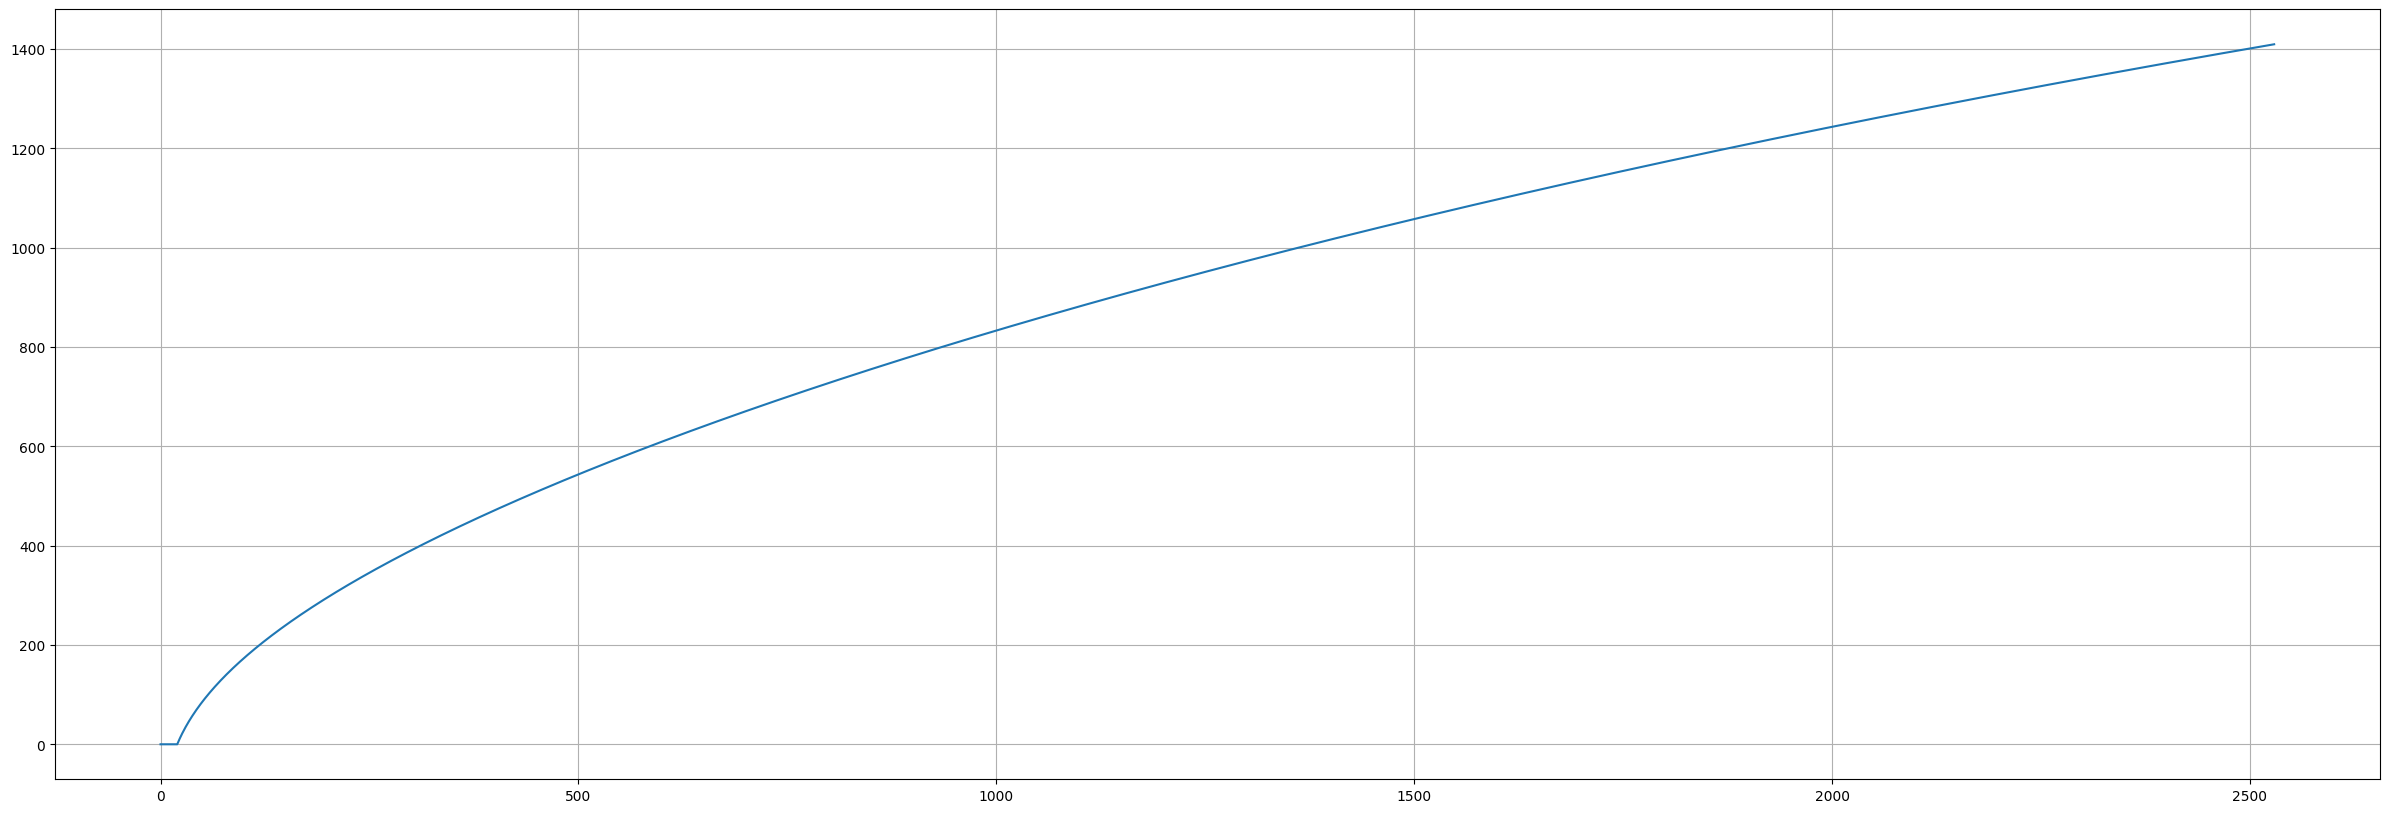

In [57]:
%%time
nfilt = int(141*4)
q1,q2,q3,q4=-4.972648,3.076921,-0.050956,0.000696
s = 10
kevs_to_drop = 20
x = symbols('x')
m = solve(q1 + q2*x + q3*x**(2) + q4*x**(3), x)[0]
params = np.array([s,q1,q2,q3,q4,m])
es = make_mel_scale(params,kevs_to_drop)
low_mel = 0
high_mel = es[-1]
mel_points = np.linspace(low_mel, high_mel, nfilt + 2)
fig,ax = plt.subplots(figsize=(30,10))
ax.plot(np.linspace(0,2529,2530),es)
ax.grid(True)

In [63]:
%%time
# main_dir_for_dataset = './GammaSpectraGeant4/'
main_dir_for_dataset = '/mnt/hgfs/vm_ubuntu_shared_folder/Wave-U-Net-Pytorch-fork/audio_examples/musdb18hq_geant4_2_classes_Eu152_n=720/'

N,alfa,mu,sigma = 5, 1, 0, 0.01
Num_drifts = 4
classes_amnt = 16
num_sets = 33
num_energies = int(channel_to_energy_channel(2048,ks0, ks1, ks2)) + 1
data ,labels_dict= make_dataset2(main_dir_for_dataset)

CPU times: user 2.71 s, sys: 0 ns, total: 2.71 s
Wall time: 3.44 s


In [64]:
data_mono = data.copy()
# label = 'other'
label = 'Eu-152'
data_mono['nuclide'] = [label for k, zz in enumerate(data_mono['label'].values)]
data_mono.drop(columns='label',inplace=True)
data_mono

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,2521.0,2522.0,2523.0,2524.0,2525.0,2526.0,2527.0,2528.0,2529.0,nuclide
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.099520,0.099504,0.100310,0.129462,0.099162,0.100034,0.099283,0.097997,0.132513,Eu-152
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003643,0.003685,0.004093,0.005025,0.003110,0.003625,0.003193,0.002362,0.007839,Eu-152
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.078368,0.078368,0.078983,0.101828,0.078932,0.077517,0.078740,0.081087,0.087227,Eu-152
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.082627,0.082627,0.083275,0.107339,0.083369,0.081507,0.083116,0.086202,0.089356,Eu-152
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.081036,0.081036,0.081672,0.105196,0.082274,0.079167,0.081852,0.087002,0.078566,Eu-152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.114741,0.141242,0.138258,0.122092,0.102234,0.110081,0.128311,0.148273,0.109004,Eu-152
108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.062102,0.071795,0.066861,0.053903,0.049680,0.043006,0.046802,0.055571,0.022222,Eu-152
109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.039427,0.039424,0.039729,0.051325,0.039084,0.039935,0.039199,0.037833,0.055769,Eu-152
110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.055648,0.055648,0.056084,0.072398,0.055432,0.055974,0.055505,0.054607,0.072891,Eu-152


In [12]:
ncldsss_lst = np.unique(data_mono['nuclide'])
ncldsss_lst

array(['other'], dtype=object)

In [65]:
saved_model_Am_241 = load_model(f'./classification_models_mononuclides/best_model_Am-241.h5')
saved_model_Ce_141 = load_model(f'./classification_models_mononuclides/best_model_Ce-141.h5')
saved_model_Ce_144 = load_model(f'./classification_models_mononuclides/best_model_Ce-144.h5')
saved_model_Co_58 = load_model(f'./classification_models_mononuclides/best_model_Co-58.h5')
saved_model_Co_60 = load_model(f'./classification_models_mononuclides/best_model_Co-60.h5')
saved_model_Cr_51 = load_model(f'./classification_models_mononuclides/best_model_Cr-51.h5')
saved_model_Cs_134 = load_model(f'./classification_models_mononuclides/best_model_Cs-134.h5')
saved_model_Cs_137 = load_model(f'./classification_models_mononuclides/best_model_Cs-137.h5')
saved_model_Eu_152 = load_model(f'./classification_models_mononuclides/best_model_Eu-152.h5')
saved_model_Fe_59 = load_model(f'./classification_models_mononuclides/best_model_Fe-59.h5')
saved_model_I_131 = load_model(f'./classification_models_mononuclides/best_model_I-131.h5')
saved_model_Mn_54 = load_model(f'./classification_models_mononuclides/best_model_Mn-54.h5')
saved_model_Ru_103 = load_model(f'./classification_models_mononuclides/best_model_Ru-103.h5')
saved_model_Ru_106 = load_model(f'./classification_models_mononuclides/best_model_Ru-106.h5')
saved_model_Zn_65 = load_model(f'./classification_models_mononuclides/best_model_Zn-65.h5')
saved_model_Zr_95 = load_model(f'./classification_models_mononuclides/best_model_Zr-95.h5')

# saved_model_Am_241 = load_model(f'./classification_models_mononuclides/best_model_melBs_3mix_Am-241.h5')
# saved_model_Ce_141 = load_model(f'./classification_models_mononuclides/best_model_melBs_3mix_Ce-141.h5')
# saved_model_Ce_144 = load_model(f'./classification_models_mononuclides/best_model_melBs_3mix_Ce-144.h5')
# saved_model_Co_58 = load_model(f'./classification_models_mononuclides/best_model_melBs_3mix_Co-58.h5')
# saved_model_Co_60 = load_model(f'./classification_models_mononuclides/best_model_melBs_3mix_Co-60.h5')
# saved_model_Cr_51 = load_model(f'./classification_models_mononuclides/best_model_melBs_3mix_Cr-51.h5')
# saved_model_Cs_134 = load_model(f'./classification_models_mononuclides/best_model_melBs_3mix_Cs-134.h5')
# saved_model_Cs_137 = load_model(f'./classification_models_mononuclides/best_model_melBs_3mix_Cs-137.h5')
# saved_model_Eu_152 = load_model(f'./classification_models_mononuclides/best_model_melBs_3mix_Eu-152.h5')
# saved_model_Fe_59 = load_model(f'./classification_models_mononuclides/best_model_melBs_3mix_Fe-59.h5')
# saved_model_I_131 = load_model(f'./classification_models_mononuclides/best_model_melBs_3mix_I-131.h5')
# saved_model_Mn_54 = load_model(f'./classification_models_mononuclides/best_model_melBs_3mix_Mn-54.h5')
# saved_model_Ru_103 = load_model(f'./classification_models_mononuclides/best_model_melBs_3mix_Ru-103.h5')
# saved_model_Ru_106 = load_model(f'./classification_models_mononuclides/best_model_melBs_3mix_Ru-106.h5')
# saved_model_Zn_65 = load_model(f'./classification_models_mononuclides/best_model_melBs_3mix_Zn-65.h5')
# saved_model_Zr_95 = load_model(f'./classification_models_mononuclides/best_model_melBs_3mix_Zr-95.h5')

In [14]:
def gen_smix_2(num_nclds_in_mix):
    randm_ncld_clss_lst = np.random.choice(ncldsss_lst, num_nclds_in_mix, replace=False)
    wt = generate_random_weights(num_nclds_in_mix)
    wt = list(np.array(wt)*0.0 + 1.0)
    smix0 = np.zeros(num_energies)
    scnts0 = np.zeros(num_nclds_in_mix)
    for i in range(num_nclds_in_mix):
        smix = data_mono[data_mono['nuclide'] == randm_ncld_clss_lst[i]].values
        smix = smix[int(np.random.choice(np.linspace(0, len(smix) - 1, len(smix))))][:-1]
        smix0 = smix0 + smix * wt[i]
        scnts0[i] = sum(smix * wt[i])
    wtF = scnts0 / sum(scnts0)
    return randm_ncld_clss_lst, wtF, smix0

In [15]:
n_classes = 16
preds_list = np.zeros(n_classes)

data_signals = data_mono.transpose()
data_signals

verificat_df = pd.DataFrame(columns=["mixture", "Am-241",
            "Ce-141",
            "Ce-144",
            "Co-58",
            "Co-60",
            "Cr-51",
            "Cs-134",
            "Cs-137",
            "Eu-152",
            "Fe-59",
            "I-131",
            "Mn-54",
            "Ru-103",
            "Ru-106",
            "Zn-65",
            "Zr-95"])

for column_name in data_signals.columns[1:15]:
    comps = np.array(data_signals[column_name].values[-1])
    wesa = np.array([1.0])
    smix = np.array(data_signals[column_name].values[:-1]).astype(float)
    
    print(f"column_name = {column_name}: max = {smix.max()}")
        
    weights_list = np.in1d(ncldsss_lst,comps).astype(float)
    w_true_list = np.zeros(len(ncldsss_lst))
    w_true_list[np.where(weights_list == 1)] = wesa
    
    drift = np.random.normal(mu, sigma, 1)[0]
    canals_orig = np.linspace(1,smix.shape[0],smix.shape[0])
    smes = drift_spectr(canals_orig, smix,drift)[1]
    mel_mix = generate_mel_spectrum(nfilt,es,smes)
    rmspec = np.log10(mel_mix + 1)
    rms_bsln_o = rmspec/sum(rmspec)

#     preds_list[0] = saved_model_Eu_152.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
#     preds_list[1] = saved_model_Co_60.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
#     preds_list[2] = saved_model_Cs_137.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
    
    preds_list[0] = saved_model_Am_241.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
    preds_list[1] = saved_model_Ce_141.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
    preds_list[2] = saved_model_Ce_144.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
    preds_list[3] = saved_model_Co_58.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
    preds_list[4] = saved_model_Co_60.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
    preds_list[5] = saved_model_Cr_51.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
    preds_list[6] = saved_model_Cs_134.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
    preds_list[7] = saved_model_Cs_137.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
    preds_list[8] = saved_model_Eu_152.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
    preds_list[9] = saved_model_Fe_59.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
    preds_list[10] = saved_model_I_131.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
    preds_list[11] = saved_model_Mn_54.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
    preds_list[12] = saved_model_Ru_103.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
    preds_list[13] = saved_model_Ru_106.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
    preds_list[14] = saved_model_Zn_65.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
    preds_list[15] = saved_model_Zr_95.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]

    df_out = pd.DataFrame({"mixture":[column_name],
                            "Am-241":[preds_list[0]],
                            "Ce-141":[preds_list[1]],
                            "Ce-144":[preds_list[2]],
                            "Co-58":[preds_list[3]],
                            "Co-60":[preds_list[4]],
                            "Cr-51":[preds_list[5]],
                            "Cs-134":[preds_list[6]],
                            "Cs-137":[preds_list[7]],
                            "Eu-152":[preds_list[8]],
                            "Fe-59":[preds_list[9]],
                            "I-131":[preds_list[10]],
                            "Mn-54":[preds_list[11]],
                            "Ru-103":[preds_list[12]],
                            "Ru-106":[preds_list[13]],
                            "Zn-65":[preds_list[14]],
                            "Zr-95":[preds_list[15]]})
    
    print(f"i = {column_name}: {verificat_df.shape}")
    verificat_df = pd.concat([verificat_df,df_out], axis = 0, ignore_index=True)
verificat_df

column_name = 1: max = 72.26592442482001
i = 1: (0, 17)
column_name = 2: max = 87.91150844782521
i = 2: (1, 17)
column_name = 3: max = 89.14769302129929
i = 3: (2, 17)
column_name = 4: max = 92.00113972019504
i = 4: (3, 17)
column_name = 5: max = 88.99715052672528
i = 5: (4, 17)
column_name = 6: max = 90.65584983315539
i = 6: (5, 17)
column_name = 7: max = 88.68512572875991
i = 7: (6, 17)
column_name = 8: max = 94.1203999999999
i = 8: (7, 17)
column_name = 9: max = 91.20599005011991
i = 9: (8, 17)
column_name = 10: max = 89.5768176923399
i = 10: (9, 17)
column_name = 11: max = 85.82117372531991
i = 11: (10, 17)
column_name = 12: max = 75.31979656062005
i = 12: (11, 17)
column_name = 13: max = 87.7911136973199
i = 13: (12, 17)
column_name = 14: max = 87.36067287199991
i = 14: (13, 17)
column_name = 15: max = 89.4890739494399
i = 15: (14, 17)
column_name = 16: max = 73.73689124734001
i = 16: (15, 17)
column_name = 17: max = 79.44999999999993
i = 17: (16, 17)
column_name = 18: max = 76.94

,mixture,Am-241,Ce-141,Ce-144,Co-58,Co-60,Cr-51,Cs-134,Cs-137,Eu-152,Fe-59,I-131,Mn-54,Ru-103,Ru-106,Zn-65,Zr-95
0,1,0.002731,2.989830e-06,0.697018,1.158825e-09,0.154259,9.972884e-01,0.000022,4.803693e-04,9.994366e-01,0.999213,0.000466,0.000011,5.498979e-09,4.767637e-03,0.012167,3.566996e-06
1,2,0.005313,8.568181e-07,0.003318,3.993365e-03,0.000683,1.962343e-01,0.857187,7.600769e-08,1.122581e-08,0.916651,0.002025,0.001171,2.286867e-11,6.468011e-07,0.000006,1.418588e-06
2,3,0.006917,7.782425e-07,0.001415,5.996109e-03,0.009315,6.482189e-02,0.857187,1.318751e-06,3.682249e-08,0.075335,0.001889,0.022453,1.227879e-10,5.848234e-08,0.000026,1.641401e-08
3,4,0.014590,4.837226e-07,0.000786,7.044624e-03,0.014377,1.411107e-02,0.857187,5.459302e-06,7.618301e-08,0.093155,0.001615,0.035235,8.172754e-10,5.127404e-08,0.000026,2.616245e-08
4,5,0.015776,5.219759e-07,0.001507,5.003566e-03,0.013246,1.372539e-02,0.857187,1.001679e-05,1.900327e-07,0.031177,0.000957,0.052812,3.807170e-10,3.431703e-08,0.000039,1.080996e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,107,0.616876,2.236692e-08,0.000088,5.162432e-04,0.022236,2.964106e-07,0.857187,8.648769e-08,9.253924e-08,0.000765,0.000136,0.000002,9.699060e-01,5.857840e-06,0.001161,1.233542e-12
107,108,0.542875,9.314429e-09,0.000101,1.272022e-03,0.116456,5.983188e-07,0.857187,5.147605e-07,6.728734e-08,0.000005,0.000207,0.000026,8.194432e-01,4.755207e-06,0.001096,4.192266e-14
108,109,0.002708,3.462538e-06,0.000081,6.106726e-03,0.001279,6.341580e-02,0.857187,5.677495e-06,4.169519e-06,0.068895,0.002266,0.603229,2.414651e-09,1.299753e-06,0.000001,5.101246e-10
109,110,0.002537,1.562879e-06,0.000157,1.530277e-02,0.000275,1.039850e-01,0.857187,1.030728e-06,3.468730e-07,0.926289,0.005037,0.043144,4.246441e-11,8.076481e-07,0.000001,8.809428e-09


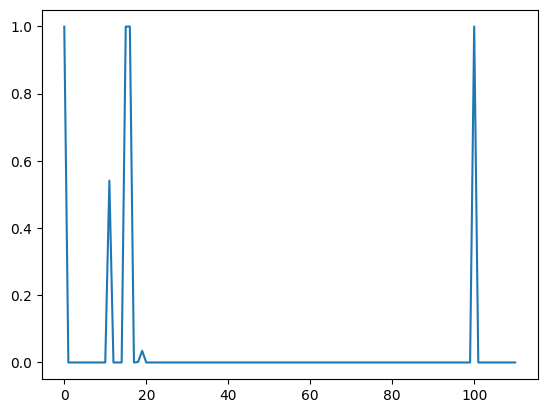

In [18]:
verificat_df["Eu-152"].values.astype("float")

plt.plot(verificat_df["Eu-152"].values.astype("float"))
plt.show()

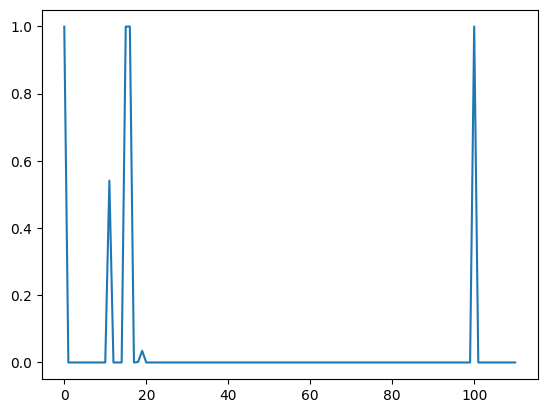

array([101, 0.007453634403645992, 0.0001565781276440248,
       2.696295086934697e-05, 2.553118549908362e-10, 0.02829507179558277,
       0.9988197684288025, 3.6845435715804342e-06, 0.0006930612726137042,
       0.9998796582221985, 0.9997319579124451, 4.23395886173239e-06,
       6.565914532075112e-07, 3.423536972119043e-16, 0.00160667032469064],
      dtype=object)

In [54]:
plt.plot(np.array(verificat_df[verificat_df.columns[9:10]]).reshape(111))
plt.show()
verificat_df[verificat_df.columns[9:10]]

verificat_df[verificat_df.columns[9:10]].values[100]
verificat_df[verificat_df.columns[0:15]].values[100]

In [ ]:
ncldsss_lst = np.unique(data_mono['nuclide'])
# comps,wesa,smix = gen_smix(1)

    
weights_list = np.in1d(ncldsss_lst,comps).astype(float)
w_true_list = np.zeros(len(ncldsss_lst))
w_true_list[np.where(weights_list == 1)] = wesa

drift = np.random.normal(mu, sigma, 1)[0]
canals_orig = np.linspace(1,smix.shape[0],smix.shape[0])

smes = drift_spectr(canals_orig, smix,drift)[1]
#smes_log = np.log10(smes+1)/sum(np.log10(smes+1))
mel_mix = generate_mel_spectrum(nfilt,es,smes)
rmspec = np.log10(mel_mix + 1)
# bsln = baseline_correction(rmspec,10,0.0001,niter=10)
# bsln = np.where(bsln<0,0,bsln)
# res = np.where((rmspec - bsln) < 0, 0, (rmspec - bsln))

rms_bsln_o = rmspec/sum(rmspec)

preds_list = np.zeros(len(ncldsss_lst))
# preds_list[10] = saved_model_I_131.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
# preds_list[6] = saved_model_Cs_134.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
# preds_list[12] = saved_model_Ru_103.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
# preds_list[15] = saved_model_Zr_95.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
# preds_list[5] = saved_model_Cr_51.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
# preds_list[0] = saved_model_Am_241.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
# preds_list[2] = saved_model_Ru_106.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
# preds_list[1] = saved_model_Ce_141.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
# preds_list[2] = saved_model_Ce_144.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
preds_list[0] = saved_model_Eu_152.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
# preds_list[0] = saved_model_Cs_137.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
# preds_list[1] = saved_model_Co_60.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
# preds_list[11] = saved_model_Mn_54.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
# preds_list[3] = saved_model_Co_58.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
# preds_list[9] = saved_model_Fe_59.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]
# preds_list[14] = saved_model_Zn_65.predict(rms_bsln_o.reshape((1,564)),batch_size = 1,verbose=0)[0][0]

# verificat_df = pd.DataFrame({'Nuclide':ncldsss_lst,'weight':weights_list,'true_weight':w_true_list,'predictions':preds_list}).T
# display(verificat_df)
verificat_df = pd.DataFrame({'Nuclide':ncldsss_lst,'weight':weights_list,'true_weight':w_true_list,'predictions':preds_list})
verificat_df

In [ ]:
data_mono.drop(columns='nuclide').values[0,:]

In [ ]:
drift

In [ ]:
rmspec

In [ ]:
ncldsss_lst = np.unique(data_mono['nuclide'])
# comps,wesa,smix = gen_smix(2)
smix = data_mono.drop(columns='nuclide').values[0,:]

# weights_list = np.in1d(ncldsss_lst,comps).astype(float)
# w_true_list = np.zeros(len(ncldsss_lst))
# w_true_list[np.where(weights_list == 1)] = wesa

drift = np.random.normal(mu, sigma, 1)[0]
canals_orig = np.linspace(1,smix.shape[0],smix.shape[0])

smes = drift_spectr(canals_orig, smix,drift)[1]
#smes_log = np.log10(smes+1)/sum(np.log10(smes+1))
mel_mix = generate_mel_spectrum(nfilt,es,smes)
rmspec = np.log10(mel_mix + 1)
# bsln = baseline_correction(rmspec,10,0.0001,niter=10)
# bsln = np.where(bsln<0,0,bsln)
# res = np.where((rmspec - bsln) < 0, 0, (rmspec - bsln))

rms_bsln_o = rmspec/sum(rmspec)